# Neural Networks

This notebook is intended to span two days. A good stopping point for the first day would be midway through the section on backpropagation, but feel free to proceed at your own pace(if you get done early there are some open-ended questions you could pursue at the bottom).

Deep learning (and thus neural networks) are currently very popular in AI and machine learning, but the core algorithms involved are actually fairly old and very simple. 

Here, we will be implementing a simple neural network, alternately known as a fully-connected(FC) network or multilayer perceptron, and then training it using the backpropagation algorithm.

To simplify the process, we will use the Pytorch framework, which provides us with an environment and pre-implemented neural network algorithms.

In [ ]:
# First, let's set up our environment
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

from sklearn.datasets import load_digits
import torch, torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display 
import time, math

In [1]:
# Allow inline plotting within the notebook and use a grayscale colormap
plt.rcParams['image.cmap'] = 'gray'

# Fix the numpy random seed so we know what we're getting
np.random.seed(seed=485)

For illustration purposes, we will use the MNIST dataset of 60,000 handwritten digits, each labeled 0 through 9. 

The problem we will try to solve on this dataset is to classify each example image as one of the 10 digits.

This dataset is considered a standard for developing and testing machine learning methods.

In [5]:
# load the data
mnist_train = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
mnist_test = torchvision.datasets.MNIST(root='data', train=False, download=True) # test data only

digits_train = mnist_train
digits_test = mnist_test

# Let's take a look at the shape of this data
print("Data shape: {}".format(mnist_train.data.size()))
print("Labels shape: {}".format(mnist_train.targets.size()))

Data shape: torch.Size([60000, 28, 28])
Labels shape: torch.Size([60000])


The dataset is ordered (starting with examples labeled '0', ending with examples labeled '9'). To generate training examples, use 60,000 random indices into the dataset.

In [7]:
indices = torch.randperm(60000)
trainimages = mnist_train.data[indices]
trainlabels = mnist_train.targets[indices]

testindices = torch.randperm(10000)
testimages = mnist_test.data[testindices]
testlabels = mnist_test.targets[testindices]

Before we train anything, it helps to get a look at our data. Let's plot the first image in our training set

In [8]:
#A plotting function to visualize images
def plot_image(image):
    nr, nc = image.size() 
    extent = [-0.5, nc-0.5, nr-0.5, -0.5]
    plt.imshow(image.numpy(), extent=extent, origin='upper', interpolation='nearest') 

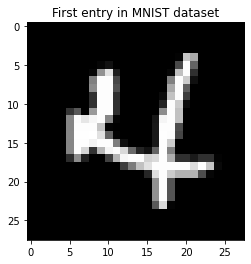

In [9]:
#Plot first image
plt.figure()
ax = plt.subplot(111)
ax.grid(False)
plot_image(trainimages[0])
plt.title("First entry in MNIST dataset")
plt.show()

Looks like a number, right? What about the mean(average) of all images in the set?

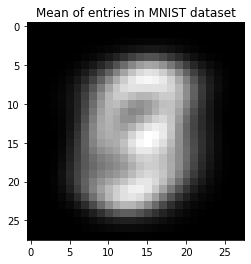

In [10]:
#Plot mean image
mean = torch.mean(trainimages.float(), dim=0)
plt.figure()
ax = plt.subplot(111)
ax.grid(False)
plot_image(mean)
plt.title("Mean of entries in MNIST dataset")
plt.show()

Basically a blur, but it lets us see what parts of the images usually contain non-0 values.

We can also look at this property by visualizing the pixels that are always zero(black) or ever non-zero(white)

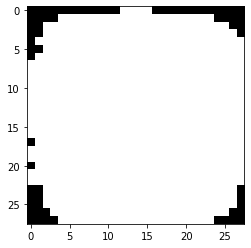

In [11]:
nonzero = torch.gt(torch.sum(trainimages.float(), dim=0), 0.0)
plt.figure()
ax = plt.subplot(111)
ax.grid(False)
plot_image(nonzero)
plt.show()

Let's look at a few more examples from the dataset. We'll define a function to display multiple images at once to help with that. Montage takes a list containing a square number of images from our data (e.g. 1, 4, 9, etc.) and displays them.

In [12]:
#Takes in an array(list, in python terminology) of images
def montage(imgstack):
    plt.figure()
    width = int(np.ceil(np.sqrt(len(imgstack))))
    height = int(np.floor(np.sqrt(len(imgstack))))
    for i in range(0, len(imgstack)):
        ax = plt.subplot(height, width, i+1)
        ax.grid(False)
        plot_image(imgstack[i])
    plt.show()

**QUESTION**
Now let's display the first 6 training examples

Can you complete the function call below to do that?

Try passing a subset of trainimages. You can select only a slice of the whole array like so:

trainimages[start:end]

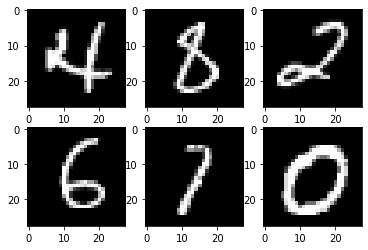

In [13]:
montage(trainimages[:6])

**QUESTION**

Next, can you print out the labels corresponding to each image above? \
You can select a range from trainlabels the same way as you did above.

In [14]:
print(trainlabels[:6])

tensor([4, 8, 2, 6, 7, 0])


Okay, we've looked at our data, but before we train any neural networks on it, let's take a moment to familiarize ourselves with the basic neural network algorithm.

---

## Neurons 101

Let's illustrate with the simplest possible neural "network."  
Suppose we have a single neuron $y$ that computes a function of one input:
$y = Wx + b$.

$y$, $x$, $b$, and $W$ are all scalar values (single numbers).

All we do is take in a single value $x$, multiply it by some number we have learned, $W$, and add another number $b$ to it.

Let's suppose for a moment that we want $y$ to be 1 or greater if $x$ is less than or equal to 0, and $y$ should be less than 1 if $x$ is greater than 0.

If we want that to be true, we need to find values of $W$ and $b$ which make $y$ take the proper value as a function of $x$.

---



**QUESTION**
Can you think of values for $W$ and $b$ that make $y$ behave the way we want?

Sketch out the shape of this function ($y$ as a function of $x$)

---

### Parameter Fitting

In this case finding values by hand is easy, but what about harder cases? How can we find values for $W$ and $b$ that work for any desired function?

There are many answers to this question across the fields of machine learning and optimization (you may recall some such methods from previous modules). For neural networks, we use **stochastic gradient descent** along with **backpropagation** to fit these values.

---

### Loss Functions

Suppose we randomly guess that $W$ should be 1 and $b$ should be 0.

While we don't know what the right values of $W$ and $b$ are, we do know what the desired behavior of $y$ is.

We also know what our current function is using $W=1$ and $b=0$. In fact, we can compute a difference between the current function and the desired behavior. For example, the following:

$ L = \begin{cases}
    1 - y\ \text{if}\ x \leq 0\\
    y - 1\ \text{if}\ x \geq 0\\
 \end{cases} $
  
Let's look at this function for a minute. We have two cases, but they're mostly the same, so let's just think about the top one. $L$ is a function that should be small when $y$ does what we want (negative values are small), and large when it does not. This lets us evaluate $y$'s behavior and how it differs from the behavior we want for any given value of $x$.

If we have a function $L$ that describes how $y$ differs from the function we want, it turns out we can actually compute how $W$ and $b$ should change to make the value of $L$ smaller, and thus **make $y$ behave as desired.**

---

The ultimate goal is to reduce the values of the loss function $L$. If we know how the loss function $L$ will change as a function of $W$, we can change the value of $W$ to make $L$ smaller. For example, if we know when $W = 1$ that making $W$ bigger makes $L$ smaller, we can make $W$ bigger and get closer to our goal of making $L$ as small as possible.

Unfortunately, this relationship might not hold for other values of $W$, or for the same value of $W$ but when $x$ or $b$ are different values.

---

It's easy to evaluate how to change $W$ with all other variables fixed, so let's do so. This method is called **stochastic gradient descent (SGD)**):

1. Compute how $W$ affects $L$ (for example, we can compute the value of $L$ given $W = 1$ and $W = 1.01$ and see how $L$ changes. 

2. Change $W$ by a little bit (if this is too large we might overshoot the correct value of $W$ and end up making things worse, so we have to go slowly).

3. Get a new value for $x$ (from our training set) and run the network using our new value of $W$.

4. Go back to 1, repeat until $L$ is small (we can set some threshold that determines when it is small enough).

We can also do the same process for $b$ (we can compute changes to each the same way).


---

Ok, this sounds good, but how should we figure out how changing $W$ affects $L$? Computing it discretely can be error-prone, and we have to do the same process separately for each variable we want to fit. What if we had hundreds or thousands of variables?

Turns out, we can compute exactly how to change each variable in parallel, no matter how many we have, using **Backpropagation** a.k.a. the chain rule for partial derivatives. If you take multivariate calculus this topic will be covered in more detail, but for now the basic intuition is simple:

* The derivative of a function $L$ with respect to one of its variables is another function (let's call this $\frac{dL}{dW}$ in the case of $W$) that describes exactly how that function changes as the variable changes. This is a *partial derivative*.

* If the entire function we want to compute is too big, we can decompose the derivative into steps: $L$ is a function of $y$, which is a function of $W$ in turn. We can say $\frac{dL}{dW} = \frac{dL}{dy}\frac{dy}{dW}$. This is the chain rule from elementary calculus: just multiply the individual derivatives!

* This means we only need to compute each of $\frac{dL}{dy}$ and $\frac{dy}{dW}$ individually, which ends up being much easier to do, especially if your full function is very large(as it is for most neural networks).

* We can also compute a derivative $\frac{dL}{db}$ for our other variable. In each case, we assume all other values ($b$ and $x$ in the case of $\frac{dL}{dW}$ and $W$ and $x$ in the case of $\frac{dL}{db}$) are *constant* and do not change. Because of this, we still need to make small steps using SGD above.

We won't go over how to compute deriviatives right now. Any *continuous* function (a function $f(x)$ has this property if the function exists for all values of $x$) is *differentiable* (derivatives can be computed), which means we can compute a derivative for most functions. 

---

You now know the core math behind neural networks. This is what makes neural networks powerful: we compute how to change each variable to improve our objective function while making small changes to the variables, repeating for many different inputs. 

Now, how can we apply this to our example network from before? Take three derivative functions:

* $\frac{dL}{dy} = \begin{cases}
    -1 & \text{if } x \leq 0\\
    1 & \text{if } x > 0
 \end{cases} $
  
* $\frac{dy}{dW} = x$
* $\frac{dy}{db} = 1$ 

**Questions**

Write down $\frac{dL}{dW}$ and $\frac{dL}{db}$. If $x = 2$, what will each of them be? How about for $x = -3$? $x = 10$?

We can update our parameters as $W_{t+1} = W_t -eta *frac{dL}{dW}$
$\eta$(the Greek letter "eta") is a number, usually called the *learning rate(LR)* which specifies how much we should change for each iteration of SGD. $t$ indicates which iteration we are on(e.g. the first iteration, producing parameters to be used in the second iteration, and so on). Normally we might do some thousands of iterations, depending on our data.

Using the sequence of values of $x$ above and $\eta = 0.1$, what will $W$ and $b$ be after doing SGD for each of them in the given order? Will their values be different if the values of $x$ were presented in a different order?

(Advanced) Now suppose we add another layer to our network, so we have $y_1 = W_1x + b_1$ and $y_2 = W_2y_1 + b_2$, with $L$ taking $y_2$ in place of $y$. What is $\frac{dL}{dW_1}$? Remember that the chain rule/backpropagation can be applied multiple times, and that $y_2$ is a function of $y_1$.


Okay, now that we understand neural networks and have looked at our data, let's define a simple neural network, consisting of 10 neurons, one for each digit.

In [15]:
class SimpleNet(nn.Module):

  #Initialize some components of our network
  def __init__(self, n_inputs, n_neurons = 10):
    super(SimpleNet, self).__init__()
    
    self.n_inputs = n_inputs
    self.n_neurons = n_neurons
    
    #Pre-implemented FC layer. You will implement this yourself later.
    #Takes in an MNIST image(usually 28 by 28 pixels) and outputs 10 values
    
    #QUESTION: If x is an image and y the output, with W and b being weights
    #and biases, what function does this compute?
    #QUESTION: What is the shape of the weight matrix of this network?
    #Hint: For a fully-connected layer, it needs a value mapping each
    #input value to each output value
    self.fc = nn.Linear(self.n_inputs, self.n_neurons)
    
  # Computes the "forward pass" of the network.
  # In this case, we take in an image x, flatten it into a vector,
  # matrix multiply it with the weight matrix, and add the bias vector.

  # The result is 10 values, which, with the right loss function,
  # we can interpret as the probability of the given image being each of 0-9.

  def forward(self, x):
    # Apply the network
    x = self.fc(x)
    return x
  
    

If each image were 2 x 2 pixels and we only had three digit classes, what would the above network look like?

In [16]:
# Let's define a function to visualize our training performance
def visualize(t, errcl, w, x):
    errorrate = np.divide(
        np.cumsum(errcl[: t + 1]),
        range(1, t + 2)
    )

    display.clear_output(wait=True)

    plt.subplot(1, 3, 1)
    plot_image(w.view((28,28)))
    plt.title("weight vector at t = " + str(t + 1))

    plt.subplot(1, 3, 2)
    plot_image(x.view((28,28)))
    plt.title("input vector")

    plt.subplot(1, 3, 3)
    plt.plot(errorrate, color='red')
    plt.title("average class error = " + str(errorrate[t]))
    #plt.ylim(0, 1)

    plt.subplots_adjust(wspace=.5)

    plt.gcf().set_size_inches(18.5, 10.5)
    display.display(plt.gcf())

Let's define the parameters we need to train our network

In [17]:
n = 28*28   # number of image pixels
m = 60000   # number of images in training set
eta = 0.0000001  # learning rate parameter
tmax = 60000   # number of learning updates

In [18]:
# Let's initialize our network
net = SimpleNet(n, 10)


Let's also define an optimizer. This object is responsible for changing the network's weights based on the gradient computed by the backwards pass.

We will also need to define our loss function. We won't get into the math, but the cross-entropy loss is standard for classification. It takes in a set of values(one for each digit), weights them to produce a set of values that sum to 1 (representing the probability that this image is each digit class), and then compares to the "true probability" (probability 1 for the correct class, 0 for the other 9).

In [19]:
opt = torch.optim.SGD(net.parameters(), lr = eta)

loss_func = nn.CrossEntropyLoss()

Finally, here's our core training loop.
We will do the following tmax times:

1. At each iteration we get a new image at random
2. We run our network on the image
3. Then we compute the error, delta, by comparing the output to our known label for the digit \
4. We then update our network using that delta.

/home/feamster/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/feamster/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/feamster/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same

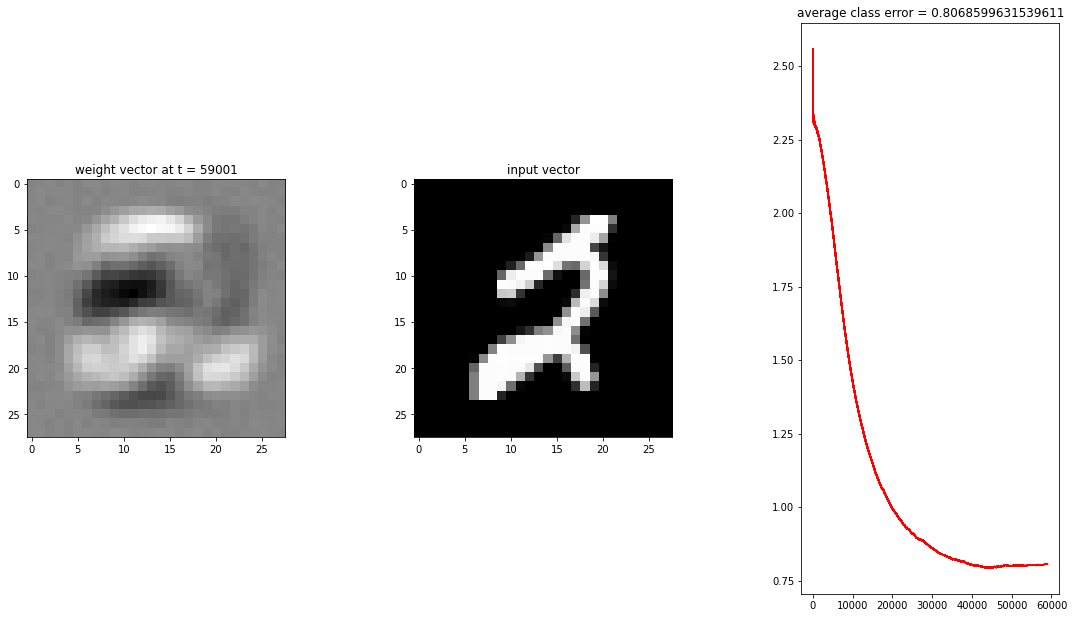

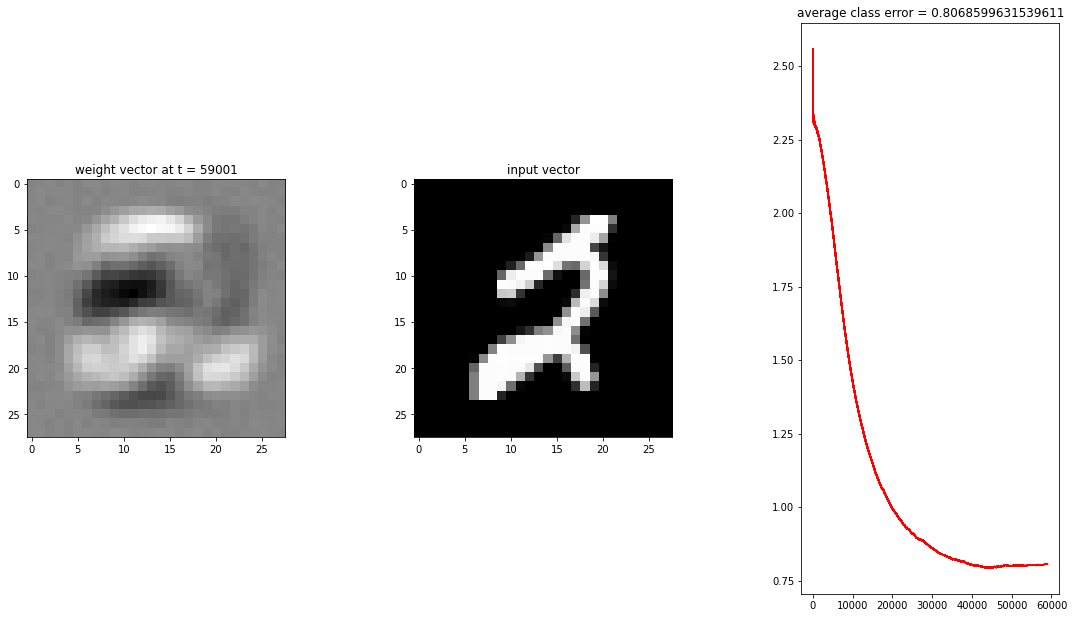

In [20]:
losses = []
for t in range(0, tmax):     # iterate over the train steps
    i = torch.floor(m*torch.rand(1)).long()    # choose a random example
    x = trainimages[i].view(-1)                # flatten image
    x = x.float() / 255.0                      # normalize max value to one 
    label = trainlabels[i]  # get true label as a float
    probs = net(x)
    loss = loss_func(probs.unsqueeze(0), label)
    losses.append(loss.item()) # for visualization below
    loss.backward()    #Call backwards to do backprop
    opt.step()
    if t % 1000 == 0:    # display every 1000 time steps
        visualize(t, np.array(losses), net.fc.weight[label,:].detach(), x)        
        time.sleep(0.01)    

Take a look at the output above. The left plot shows the weights learned for the current image class. Note that it resembles a "canonical" or "average" digit of that class. Why do you think that is? How might this set of weights make sense as a way to detect the respective digit class?

Let's also test our network on the test set!

In [21]:
correct = 0.0
total = 0.0
for i in range(len(testimages)):
  x = testimages[i].view(-1)
  x = x.float() / 255.0                      # normalize max value to one 
  label = testlabels[i]  # get true label as a float
  probs = net(x)
  predicted = F.softmax(probs).max(0)[1]
  total += 1
  correct += (predicted == label).sum().item()
  
print("Accuracy of the network on " + str(len(testimages)) + " test images: " + str(100 * correct/total) + "%")

/home/feamster/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Accuracy of the network on 10000 test images: 89.21%


How did we do? Much better than chance, certainly!

Okay, so we've now got a simple neural network for classifying MNIST digits!
However, we did it using a lot of built-in code in pytorch. Let's go back and implement some of that for our own satisfaction.

**Question** \
Here's a new version of the network we defined above. Modify the forward(self, x) function to fill in the blanks.

**HINT**: Use the torch.matmul() function to multiply the inputs by the weights in one pass.

(**ADVANCED**) Let's add two more layers to our network! They should look similar to the first, but will make our network much more powerful. The network should look something like:
* layer 1: n_inputs -> 32 neurons
* layer 2: 32 neurons -> 64 neurons
* layer 3: 64 neurons -> n_neurons


In [22]:
#Let's define our own FC layer module
class ourLinear(nn.Module):
  
  def __init__(self, n_inputs, n_outputs):
    super(ourLinear, self).__init__()
    self.n_inputs = n_inputs
    self.n_outputs = n_outputs
    
    #Define parameters containing our weights and biases
    #Parameter objects are Pytorch's way of indicating what variables
    #need gradients computed via backpropagation
    #Weight matrix needs to be specified with the number of outputs first
    self.weight = nn.Parameter(torch.Tensor(self.n_outputs, self.n_inputs))
    self.bias = nn.Parameter(torch.Tensor(self.n_outputs))
    #also need a variable to hold the input to this layer for use in the backwards pass
    self.input = None
    
    self.reset_parameters()
    
  #Define the forward pass for this layer
  def forward(self, x):
    #Save x for use in backwards pass gradient computation
    #QUESTION: Why do we need x for the backward pass?
    self.input = x.detach() #detach to avoid interfering with autograd
    #Fill in here
    #Multiply with weights
    x = torch.matmul(x, self.weight.t())
    #Add bias
    x = x + self.bias
    return x
  
  #Compute backwards pass given gradient of loss with respect to output
  def backward(self, grad_output):
    grad_output = grad_output.detach()
    
    #compute gradients with respect to each set of weights and the input
    self.weight.grad = torch.matmul(self.input, grad_output)
    
    self.bias.grad = grad_output
    
    #Input is output of previous layer, so we can continue the backwards pass
    grad_input = torch.matmul(self.weight, grad_output)
   
    return grad_input
    
  #We need a function to initialize our weights
  def reset_parameters(self):
    #A common solution for the weight matrix is to use a uniform distribution
    stdv = 1.0 / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    #bias is commonly initialized to zero
    self.bias.data.zero_()
    

In [23]:
class SimpleNet(nn.Module):

  #Initialize some components of our network
  def __init__(self, n_inputs, n_neurons = 10):
    super(SimpleNet, self).__init__()
    
    self.n_inputs = n_inputs
    self.n_neurons = n_neurons
    
    #Let's use the layer we implemented above rather than the original linear layer
    self.fc = ourLinear(self.n_inputs, self.n_neurons)
    
    #Advanced implement additional layers as described above
    #self.fc2 = ourLinear(???)
    
    #self.fc3 = ourLinear(???)
    
    
  #Computes the "forward pass" of the network.
  #In this case, we take in an image x, flatten it into a vector,
  #matrix multiply it with the weight matrix, and add the bias vector
  #The result is 10 values, which, with the right loss function,
  #we can interpret as the probability of the given image being each of 0-9.
  def forward(self, x):
    #Apply the network
    #Fill-in here
    x = self.fc(x)
    #Advanced fill-in here- uncomment the lines
    #Let's apply non-linearities to make our three-layer network more expressive
    #x = F.relu(x)
    #Apply second layer
    #x = ???
    #Another non-linearity
    #x = F.relu(x)
    #Third layer
    #x = ???
    
    return x
  
  #Let's compute the backwards pass of our network manually as well this time
  #Takes as input the gradient of the network with respect to the loss function
  def backward(self, grad):
  
    #output layer backwards pass
    grad = self.fc.backward(grad)
  
    #lower layers

    grad = self.fc2.backward(grad)
    
    grad = self.fc1.backward(grad)
    
    return grad
  

Once you've completed the above, run it using the previous training code and see what you get!

If you filled in the advanced network, the performance should be much higher.

Note that Pytorch is handling the backwards pass derivatives automatically based on the forward pass functions.

**Question**
Let's fix that and define it ourselves!


In [24]:
#Let's initialize our network
net = SimpleNet(n, 10)

In [25]:
opt = torch.optim.SGD(net.parameters(), lr = eta)

loss_func = nn.CrossEntropyLoss()

In [26]:
losses = []
for t in range(0, tmax):     # iterate over the train steps
    i = torch.floor(m*torch.rand(1)).long()    # choose a random example
    x = trainimages[i].view(-1)                # flatten image
    x = x.float() / 255.0                      # normalize max value to one 
    label = trainlabels[i]  # get true label as a float
    probs = net(x)
    loss = loss_func(probs.unsqueeze(0), label)
    losses.append(loss.item())
    loss.backward()    #Call backwards to do backprop
    #Let's do the backwards pass manually!
    net.backward(loss.grad)
    opt.step()
    if t % 1000 == 0:    # display every 1000 time steps
        visualize(t, np.array(losses), net.fc.weight[label,:].detach(), x)        
        time.sleep(0.01) 

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


AttributeError: 'NoneType' object has no attribute 'detach'